<a href="https://colab.research.google.com/github/hyehyunseo/ESAA_OB/blob/main/0911_%ED%95%B8%EC%A6%88%EC%98%A8_4%EC%9E%A5_%EB%AA%A8%EB%8D%B8%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[개념 정리]**
**9/11 과제 - 핸즈온 4장 모델 훈련 p. 157-202**

---


# **CH4. 모델 훈련**

## **1. 선형 회귀**

일반적으로 선형 모델은 아래와 같이 입력 특성의 가중치 합과 편향(절편)이라는 상수를 더해 예측을 만든다

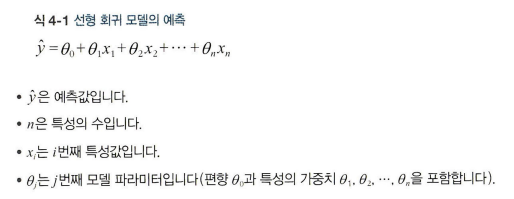

* 모델을 훈련시킨다는 것은 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것

  => 이를 위해서는 모델이 훈련 데이터에 얼마나 잘 들어맞는지 측정해야하며, 이때 널리 사용되는 성능 측정 지표는 *RMSE*

  => 따라서, 선형 회귀 모델을 훈련시키려면 RMSE를 최소화하는 세타를 찾아야한다.

* RMSE보다 평균 제곱 오차(MSE)를 사용하는 것이 좀 더 간단

  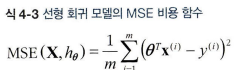


### **1) 정규방정식**

비용 함수를 최소화하는 세타값을 찾기 위한 해석적인 방법을 정규방정식이라고 한다.

  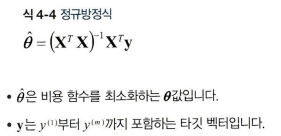

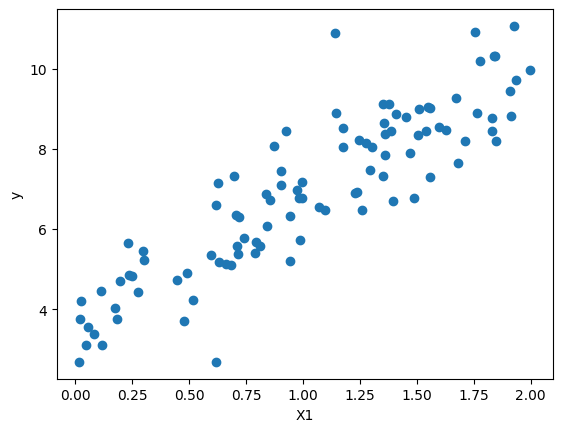

In [2]:
# 위 공식을 테스트하기 위해 선형처럼 보이는 데이터 생성
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
plt.scatter(X,y)
plt.xlabel('X1')
plt.ylabel('y')
plt.show()

In [3]:
# 정규방정식 사용해 세타 햇 계산
X_b = np.c_[np.ones((100,1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [4]:
theta_best

array([[3.6177787 ],
       [3.22011352]])

=> 기대한 값과 매우 비슷하지만 잡음때문에 원래 함수의 파라미터를 정확하게 재현하지 못함

In [5]:
# (1) theta hat 사용해 예측
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.6177787 ],
       [10.05800575]])

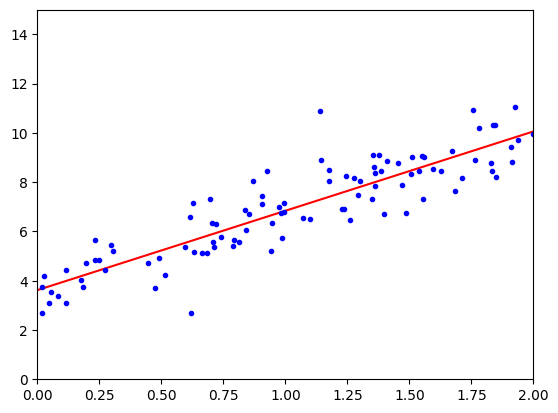

In [6]:
# 모델의 예측을 그래프에 나타내기
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
# (2) 사이킷런에서 선형 회귀 수행
# => 사이킷런은 특성의 가중치와 편향을 분리하여 저장함
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_
lin_reg.predict(X_new)

array([[ 3.6177787 ],
       [10.05800575]])

* LinearRegression 클래스는 scipy.linalg.lstsq()함수를 기반으로 함

  => 이 함수는 theta hat= (X+)*y를 계산한다. X+는 X의 유사역행렬임

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.6177787 ],
       [3.22011352]])

* 유사역행렬

  * np.linalg.pinv() 함수를 사용하면 유사역행렬을 구할 수 있음

  * 특잇값 분해(SVD)라 부르는 표준 행렬 분해 기법을 사용해 계산됨

In [9]:
np.linalg.pinv(X_b).dot(y)

array([[3.6177787 ],
       [3.22011352]])

### **2) 계산복잡도**


정규방정식은 (n+1)*(n+1) 크기가 되는 X.T *X의 역행렬을 계산함 (n: 특성수)

* 계산 복잡도는 일반적으로  일반적으로 O(n^2.4)에서 O(n^3) 사이이며, 이는 특성 수가 두배로 늘어나면 계산 시간이 대략 5.3배에서 8배로 증가함을 의미한다.

* 사이킷런의 LinearRegression 클래스가 사용하는 SVD 방법은 약 O(n^2)이며, 특성의 개수가 두 배로 늘어나면 계산 시간이 대략 4배임

  => 정규방정식이나 다른 알고리즘으로 학습된 선형 회귀 모델은 예측이 매우 빠름

## **2. 경사하강법(GD)**

경사하강법은 여로 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘

* 기본 아이디어는 비용함수를 최소화하기 위해 반복해서 파라미터를 조정

* 세타를 임의의 값으로 시작 => 파라미터 벡터에 대해 비용 함수의 현재 gradient를 계산 => gradient가 감소하는 방향으로 진행 => gradient가 최솟값에 수렴할 때까지 점진적으로 향상시킴

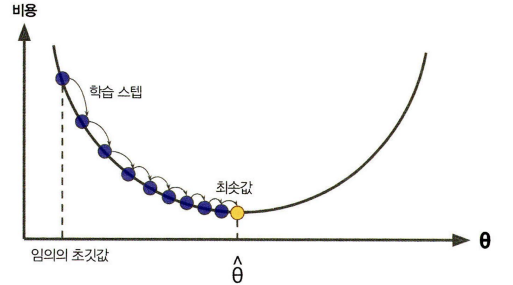

  => 이때, 학습 스텝의 크기는 비용함수의 기울기에 비례하기 때문에 파라미터가 최솟값에 가까워질수록 스텝의 크기가 점진적으로 줄어든다.

(1) 학습률 : 스텝의 크기
  * 학습률이 너무 작으면 : 알고리즘이 수렴하기 위해 반복을 많이 진행해야 함
  * 학습률이 너무 크면 : 골짜기를 가로질러 반대편으로 건너뛰게 되어 이전보다 더 높은 곳으로 갈 수도 있음
  
(2) 경사하강법의 문제점
  * 알고리즘이 왼쪽에서 시작하면 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴하는 문제
  * 알고리즘이 오른쪽에서 시작하면 평탄한 지역을 지나기 위해 시간이 오래 걸리고 일찍 멈추게 되어 전역 최솟값에 도달하지 못함

  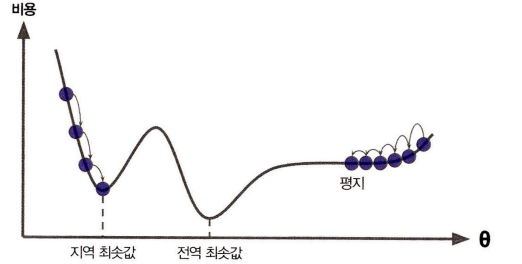

(3) 선형 회귀를 위한 MSE 비용 함수

* 어떤 두 점을 선택해 선을 그어도 곡선을 가로지르지 않는 볼록함수 (지역 최솟값이 없고 하나의 전역 최솟값만 존재한다는 의미)

  => 따라서, 경사 하강법이 전역 최솟값에 가깝게 접근할 수 있음을 보장

### **1) 배치 경사 하강법**

경사하강법을 구현하려면 각 모델 파라미터에 대해 비용 함수의 gradient를 계산해야함

매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 계산하기 때문에 배치 경사 하강법이라고 한다. (즉, 매 스텝에서 훈련 데이터 전체를 사용함)

=> 이런 이유로 매우 큰 훈련 세트에서는 아주 느림. 그러나 특성 수에 민감하지 않다는 장점

(1) 편도함수

  * 세타가 조금 변경될 때, 비용 함수가 얼마나 바뀌는지 계산

  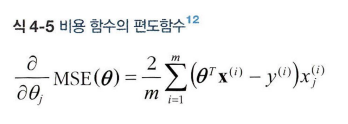

  * 아래 식은 비용함수의 (모델 파라미터마다 한 개씩인) 편도 함수를 모두 담고 있음

  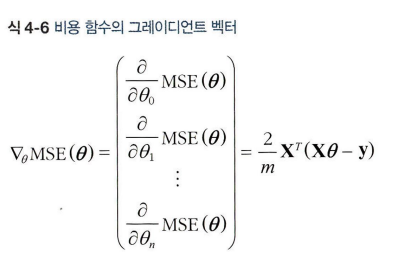



In [10]:
eta = 0.1   # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)   # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

In [11]:
theta

array([[3.6177787 ],
       [3.22011352]])

=> 정규표현식으로 찾은 것과 같음

* 학습률을 변경해본 경우

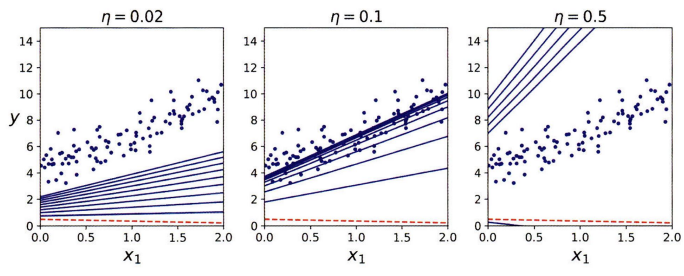

=> 왼쪽의 학습률은 너무 낮으며, 오른쪽 학습률은 너무 큼

=> 적절한 학습률을 찾기 위해서 그리드 탐색을 사용하고, 수렴하는데 너무 오래 걸리는 모델을 막기 위해 반복횟수를 제한해야함


### **2) 확률적 경사 하강법**

확률적 경사 하강법은 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 gradient를 계산한다.

=> 배치 경사 하강법의 큰 문제였던 매 스텝에서 전체 훈련 세트를 사용해 gradient를 구하는 점을 해결


* 매 반복에서 다뤄야 할 데이터가 적기 때문에 한 번에 하나의 샘플을 처리하여 알고리즘이 훨씬 빠르다.

* 확률적이기 때문에 배치 경사 하강법보다 훨씬 불안정함. 비용 함수가 최솟값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치면서 평균적으로 감소함

* 무작위성은 지역 최솟값에서 탈출시켜줘서 좋지만 알고리즘을 전역 최솟값에 다다르지 못하게 한다는 점에서 좋지 않음

  * 이 딜레마를 해결하는 방법은 학습률을 점진적으로 감소시키는 것으로 시작할 때는 학습률을 크게하고 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하게 함

  * 학습 스케쥴 : 매 반복에서 학습률을 결정하는 함수  

In [12]:
# (1) 학습 스케줄 사용한 확률적 경사 하강법의 구현

n_epochs = 50
t0, t1 = 5,50   # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1)   # 무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

In [13]:
theta

array([[3.61458014],
       [3.18076035]])

In [14]:
# (2) 사이킷런에서 SGD 방식으로 선형 회귀
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)  # max_iter : 최대 에포크 횟수. tol : 손실이 줄어들 때까지 실행되는 기준. eta0 : 학습률. penalty : 규제
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.59319645]), array([3.24852296]))

### **3) 미니배치 경사 하강법**

미니배치 경사 하강법은 각 스텝에서 미니배치라 부르는 임의의 작은 샘플 세트에 대해 gradient를 계산하는 방법

* 확률적 경사 하강법에 비해 미니배치 경사 하강법의 주요 장점은 행렬 연산에 최적화된 하드웨어 특히 GPU를 사용해서 얻는 성능 향상임

* 미니배치를 어느정도 크게 하면 파라미터 공간에서 SGD보다 덜 불규칙하게 움직이고, 결국 SGD보다 최솟값에 더 가까이 도달하게 됨 (그러나 지역 최솟값에서 빠져나오기는 더 힘들지도 모름)

(1) 세가지 경사 하강법 알고리즘의 훈련 과정이 파라미터 공간에서 움직인 경로

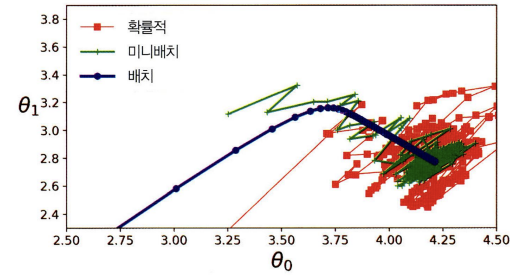

(2) 선형회귀를 통한 비교

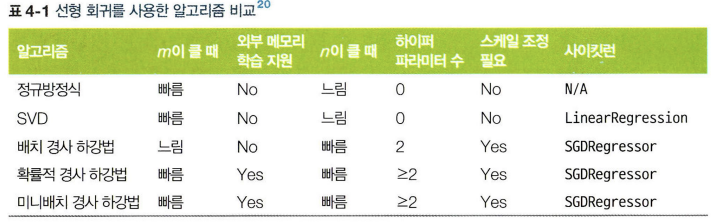

## **3. 다항 회귀**

가지고 있는 데이터가 단순한 직선보다 복잡한 형태라면 ?

=> 각 특성의 거듭 제곱을 새로운 특성으로 추가하고, 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 *다항회귀*를 사용할 수 있음

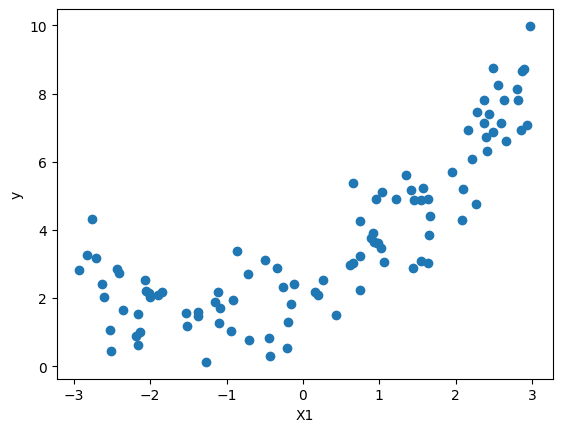

In [16]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

plt.scatter(X,y)
plt.xlabel('X1')
plt.ylabel('y')
plt.show()

=> 직선은 위 데이터에 잘 맞지 않음

* 사이킷런의 PolynomialFeatures 사용

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([1.45174253])

In [18]:
X_poly[0]

array([1.45174253, 2.10755638])

=> X_poly는 원래 특성 X와 이 특성의 제곱을 포함함

In [19]:
# 확장된 훈련 데이터에 LinearRegression적용
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.20469857]), array([[0.98432617, 0.39188423]]))

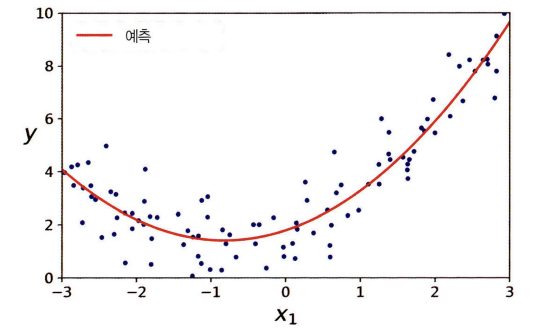

## **4. 학습 곡선**

고차 다항 회귀를 적용하면 보통의 선형 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추려 할 것임

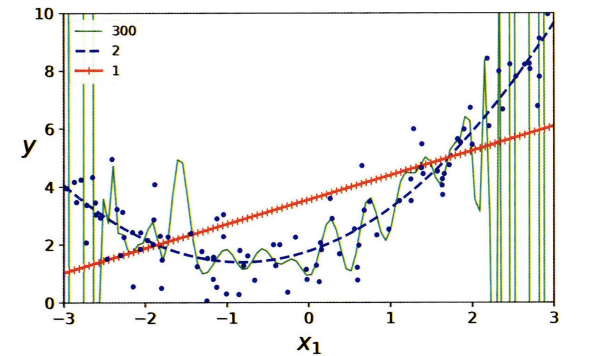

=> 위 고차 다항 회귀 모델은 훈련 샘플에 가능한 가까이 가려고 구불구불하게 나타나있으며, 심각하게 훈련 데이터에 과대적합 됨.

=> 반면에 선형 모델은 과소 적합됨

(1) 학습 곡선

훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(or 훈련 반복)의 함수로 나타내는 그래프

* 이 그래프를 생성하기 위해서는 단순히 훈련 세트엣 크기가 다른 서브 세트를 만들어 모델을 여러번 훈련시키면 됨

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="training set")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
  plt.ylim([0, 3.0])
  plt.xlabel('Train Set Size')
  plt.ylabel('RMSE')
  plt.legend()

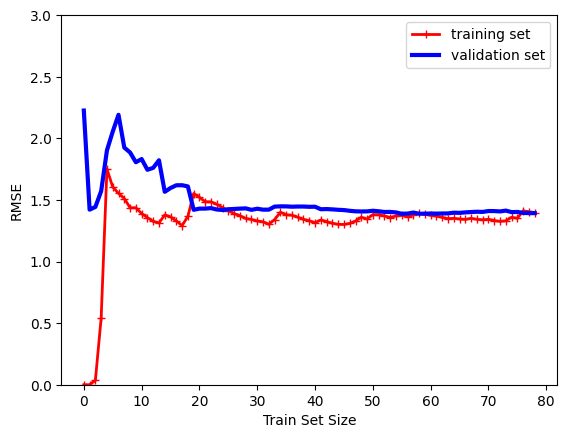

In [22]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

=> 과소적합된 모델

  * 훈련 데이터 성능을 보면
    * 샘플이 추가됨에 따라 잡음이 존재
    
    * 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능
    * 곡선이 어느 정도 평편해질 때까지 오차가 계속 상승함

  * 검증 데이터 성능을 보면
    * 모델이 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화될 수 없어서 검증 오차가 초기에 매우 큼
    * 샘플이 추가됨에 따라 검증 오차가 감소

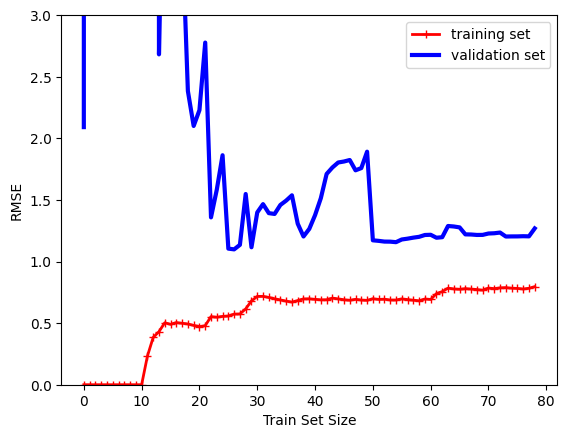

In [23]:
# 같은 데이터에서 10차 다항 회귀 모델의 학습 곡선
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)

* 이전과의 차이점
  * 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
  * 두 직선 사이에 공간이 있음
  
    => 이 말은 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낮다는 뜻이고 과대 적합 모델의 특지임

## **5. 규제가 있는 선형 모델**

과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것

### **1) 릿지 회귀**

릿지 회귀는 규제가 추가된 선형 회귀 버전

* 규제항이 비용 함수에 추가되며, 이는 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 작게 유지되도록 노력함

* 규제항은 훈련하는 동안에만 비용 함수에 추가되며 훈련이 긑나면 모델의 성능을 규제가 없는 성능 지표로 평가함

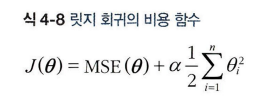

* 하이퍼파라미터 알파 : 모델을 얼마나 규제할지 조절
  * 알파 = 0이면 릿지 회귀는 선형 회귀와 동일
  * 알파가 아주 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 됨

* 릿지 회귀는 입력 특성의 스케일에 민감하기 때문에 수행하기 전에 데이터의 스케일을 맞추는 것이 중요함

In [24]:
# (1) 정규방정식을 사용하여 릿지 회귀
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.07890333]])

In [25]:
# (2) 확률적 경사 하강법을 사용하여 릿지 회귀
## penalty : 사용할 규제를 지정함
## l2 : SGE가 비용 함수에 가중치 벡터의 l2 노름의 제곱을 2로 나눈 규제항을 추가하도록 함 (즉, 릿지 회귀)
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.06975519])

### **2) 라쏘 회귀**

가중치 벡터의 l1 노름을 사용한 규제 방법


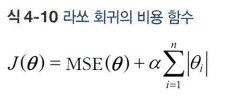

* 라쏘 회귀의 중요한 특징은 덜 중요한 특성의 가중치를 제거하려고 한다는 점

  => 자동으로 특성 선택을 하고 희소 모델을 만든다. (0이 아닌 특성의 가중치가 적음)

* 라쏘를 사용할 때 경사하강법이 최적점 근처에서 진동하는 것을 막으려면 훈련하는 동안 점진적으로 학습률을 감소시켜야함

* 라쏘의 비용함수는 theta=0에서 미분 불가능하지만, 서브그레디언트 벡터를 사용하면 경사하강법을 적용하는데 문제가 없다.

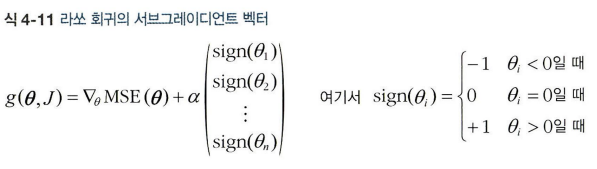

In [26]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1) # 대신 SQDRegressor(penalty='l1') 사용 가능
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.04533028])

### **3) 엘라스틱넷**

엘라스틱넷은 릿지 회귀와 라쏘 회귀를 절충한 모델이다.

* 규제항은 릿지와 회귀의 규제항을 단순히 더해서 사용하며, 혼합 정도는 혼합 비율 r을 사용해 조절한다.

* r=0이면 엘라스틱넷은 릿지회귀와 같고, r=1이면 라쏘 회귀와 같다.

Q. 그렇다면 보통의 선형회귀, 릿지, 라쏘, 엘라스틱넷을 언제 사용해야할까?

=> 적어도 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피해야한다.

=> 릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷이 낫다.

  * 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 라쏘가 문제를 일으키기 때문에 엘라스틱넷을 선호함

In [28]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([5.04483831])

### **4) 조기 종료**

반복적인 학습 알고리즘을 규제하는 방식으로, 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것

* 즉, 에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측 에러와 검증 세트에 대한 예측 에러가 줄어듬. 그러나 잠시 후 감소하던 검증 에러가 멈추었다가 다시 상승
  
  => 이는 모델이 훈련 데이터에 과대적합되기 시작함을 의미

  => 따라서 검증 에러가 최소에 도달하면 훈련을 멈춰야함


  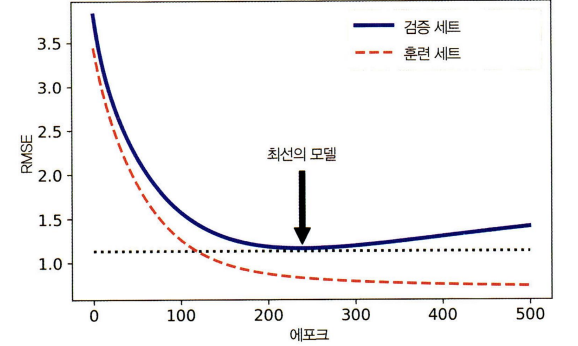


 * 확률적 경사 하강법이나 미니배치 경사하강법에서는 곡선이 매끄럽지 않아 최솟값에 도달했는지 확인하기 어려움.

  => 검증 에러가 일정시간동안 최솟값보다 클 때 학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌린다.

In [29]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias = False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train)
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

=> warm_start=True로 지정하면 fit() 메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어감

## **6. 로지스틱 회귀**

로지스틱 회귀는 샘플이 특정 클래스에 속할 확률을 추정하는데 널리 사용된다.

* 추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측하며, 이를 이진 분류기라고 함

### **1) 확률 추정**

로지스틱 회귀는 선형 회귀 모델과 같이 입력 특성의 가중치 합을 계산하고 편향을 더한다.

* 대신 선형 회귀처럼 바로 결과를 출력하지 않고 결괏값의 로지스틱을 출력한다.

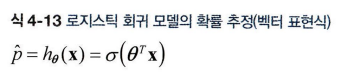


* 로지스틱은 0과 1 사이의 값을 출력하는 시그모이드 함수이다.

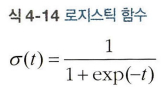

### **2) 훈련과 비용 함수**

로지스틱 회귀 모델의 훈련 목적은 양성 샘플에 대해서는 높은 확률을 추정하고 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터를 찾는 것임

* 훈련 샘플 x에 대해 나타난 비용함수 식

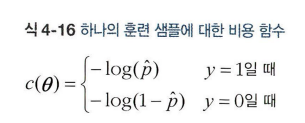

* 로그 손실 : 전체 훈련 세트에 대한 비용함수는 모든 훈련 샘플의 비용을 평균한 것

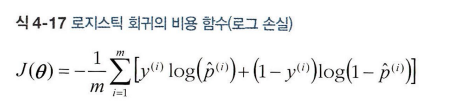

### **3) 결정 경계**



In [31]:
# 데이터 불러오기
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())
X = iris["data"][:,3:]   # 꽃잎의 너비
y = (iris["target"]==2).astype(np.int)   # 1 Iris-Virginica면 1, 그렇지 않으면 0

In [32]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

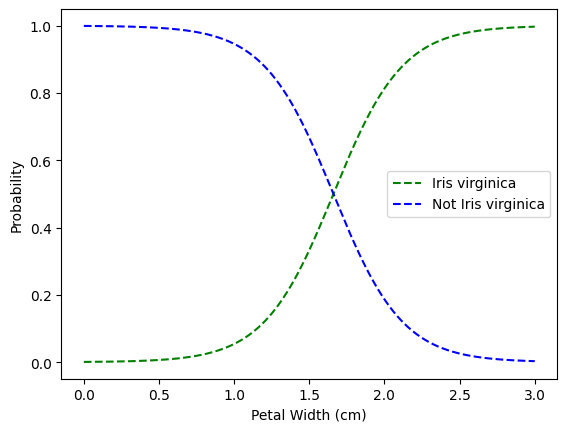

In [34]:
# 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률 계산
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], "g--", label="Iris virginica")
plt.plot(X_new, y_proba[:,0], "b--", label="Not Iris virginica")
plt.legend()
plt.xlabel('Petal Width (cm)')
plt.ylabel('Probability')
plt.show()

=> 양쪽의 확률이 똑같이 50%가 되는 1.6cm 근방에서 결정 경계가 만들어진다.

=> 곷잎 너비가 1.6cm보다 크면 분류기는 Iris-Verginica로 분류하고 그보다 작으면 아니라고 예측할 것임

In [35]:
log_reg.predict([[1.7],[1.5]])


array([1, 0])

### **4) 소프트맥스 회귀(다항 로지스틱 회귀)**

로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있다.

* 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 Sk(x)를 계산하고, 그 점수에  소프트맥스 함수를 적용하여 각 클래스의 확률을 추정한다.

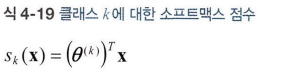

* 각 클래스는 자신만의 파라미터 벡터가 있으며, 이 벡터들은 파라미터 행렬에 행으로 저장됨

* 로지스틱 회귀 분류기와 마찬가지로 소프트맥스 회귀 분류기는 추정확률이 가장 높은 클래스를 선택함

* 모델이 타깃 클래스에 대해 높은 확률을 추정하도록 만드는 것이 목적
  * 크로스 엔트로피 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 이 목적에 부합함

* 사이킷런의 LogisticRegression은 클래스가 둘 이상일 때 기본적으로 일대다 전략을 사용한다.

  * multi_class 매개변수를 'multinomial'로 바꾸면 소프트맥스 회귀를 사용할 수 있음
  * 소프트맥스 회귀를 사용하려면 solver 매개변수에 'lbfgs'와 같이 소프트맥스 회귀를 지원하는 알고리즘을 지정해야함
  * 또한 기본적으로 하이퍼파라미터 C를 사용하여 조절할 수 있는 l2 규제가 적용됨

In [36]:
X = iris["data"][:, (2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [37]:
softmax_reg.predict([[5,2]])

array([2])

In [38]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])